I am trying a different approach..

In [ ]:
#data_prep.ipynb

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

def setup_mpl():
    mpl.rcParams['font.family'] = 'Ti       mes New Roman'
    mpl.rcParams['lines.linewidth'] = 2
    return None
setup_mpl()

Let us start out by using nested dictionaries:

In [3]:
data_dict = {}

for d in Path('../data/raw/dataset').glob('D1_*'):
    d_name = d.name
    data_dict[d_name] = {}
    
    for id_ in d.glob('ID_*'):
        id_name = id_.name
        data_dict[d_name][id_name] = {}
        
        for round_ in id_.glob('round_*'):
            round_name = round_.name
            data_dict[d_name][id_name][round_name] = {}
            
            for phase in round_.glob('phase*'):
                phase_name = phase.name
                data_dict[d_name][id_name][round_name][phase_name] = {} 
                
                for file in phase.glob('*.csv'):
                    if file.name not in ('response.csv',):
                        temp_df = pd.read_csv(file, index_col=None)
                        temp_df['time'] = pd.to_datetime(temp_df['time'], format='%Y-%m-%d %H:%M:%S.%f')
                        temp_df['time_passed'] = (temp_df['time'] - temp_df['time'].iloc[0]).apply(lambda x: x.total_seconds())
                        
                        # Save dataframe in nested dictionary
                        data_dict[d_name][id_name][round_name][phase_name][file.stem] = temp_df

In [4]:
print(data_dict)
data_dict['D1_1']['ID_1']['round_1']['phase_1']['BVP']

{'D1_1': {'ID_1': {'round_1': {'phase1': {'BVP':        Unnamed: 0    BVP                       time  time_passed
0               0 -61.33 2021-12-17 16:11:54.953125     0.000000
1               1 -56.25 2021-12-17 16:11:54.968750     0.015625
2               2 -47.83 2021-12-17 16:11:54.984375     0.031250
3               3 -35.69 2021-12-17 16:11:55.000000     0.046875
4               4 -20.53 2021-12-17 16:11:55.015625     0.062500
...           ...    ...                        ...          ...
28619       28619 -65.00 2021-12-17 16:19:22.125000   447.171875
28620       28620 -67.25 2021-12-17 16:19:22.140625   447.187500
28621       28621 -69.35 2021-12-17 16:19:22.156250   447.203125
28622       28622 -70.85 2021-12-17 16:19:22.171875   447.218750
28623       28623 -70.90 2021-12-17 16:19:22.187500   447.234375

[28624 rows x 4 columns], 'EDA':       Unnamed: 0       EDA                    time  time_passed
0              0  0.185827 2021-12-17 16:11:55.000         0.00
1        

KeyError: 'phase_1'

What are we trying to achieve:

Threee coherts; each should have three phases. Meaning we should have nine graphs for each variable. Issues; third cohert is annoying, so let us start by making the first two work:
We need to average across participants, and rounds, but keep phases, do they have equal lengths? Probably not...

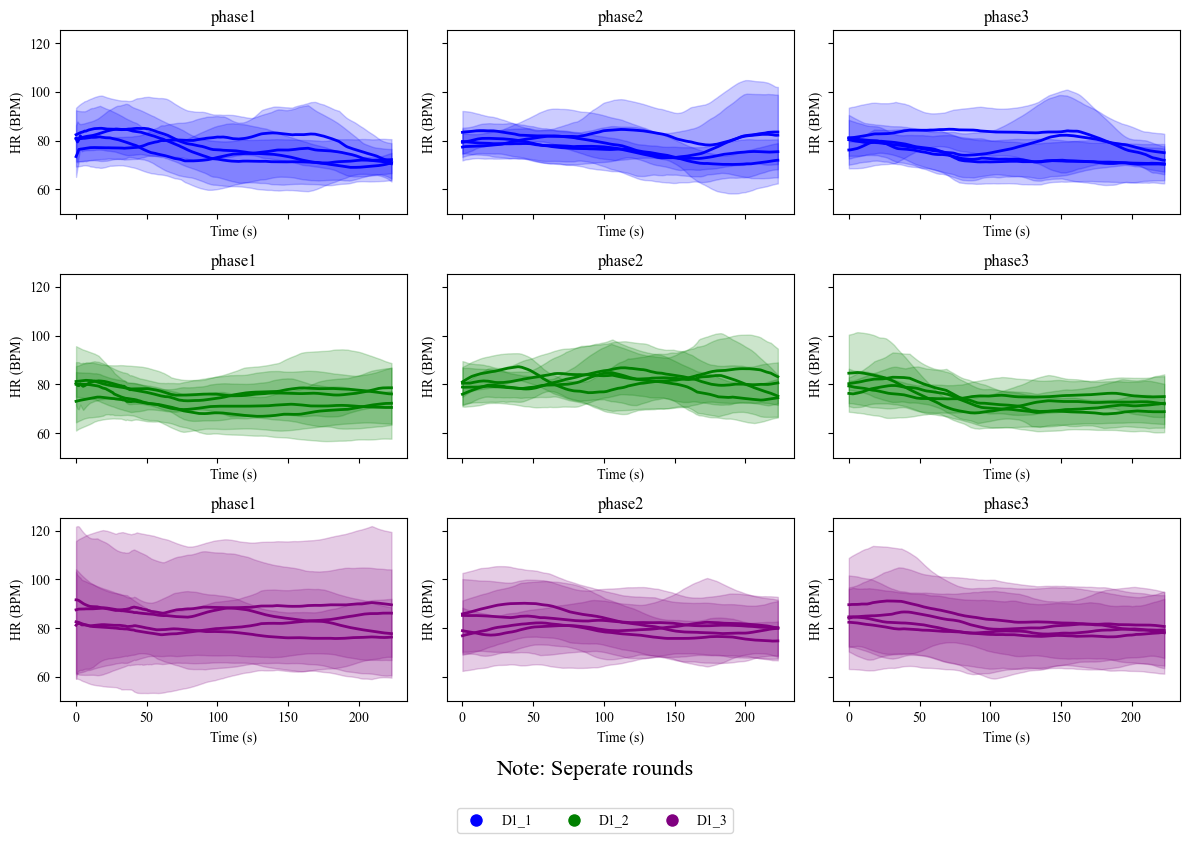

In [3]:
from matplotlib.lines import Line2D
# create empty dictionaries to store the average and standard deviation for each phase and cohort
avg_dict = {}
std_dict = {}

min_len_hr = min(len(data_dict[cohort][id][round_][phase]['HR']['HR'].tolist()) for cohort in data_dict for id in data_dict[cohort] for round_ in data_dict[cohort][id] for phase in data_dict[cohort][id][round_])

merged_cohorts = {
    'D1_1': ['D1_1'],
    'D1_2': ['D1_2'],
    'D1_3': ['D1_3_1', 'D1_3_2', 'D1_3_3', 'D1_3_4'] 
}

for merged_cohort in merged_cohorts:
    for round_ in ['round_1', 'round_2', 'round_3', 'round_4']:
        for phase in ['phase1', 'phase2', 'phase3']:
            key = f'{merged_cohort}_round{round_}_{phase}'
            hr_list = []

            for cohort in merged_cohorts[merged_cohort]:
                # iterate through each participant's data for the phase in the round
                for id in data_dict[cohort].keys():
                    hr_ts = data_dict[cohort][id][round_][phase]['HR']['HR'].tolist()

                    # Series differ in length, not sure how we should solve this problem... for now I'll introduce zero-padding...
                    if len(hr_ts) > min_len_hr:
                        hr_ts = hr_ts[:min_len_hr]

                    hr_list.append(hr_ts)

            if len(hr_list) > 0:


                # compute average and standard deviation across all participants for the phase in the round
                avg_hr = np.mean(np.vstack(hr_list), axis=0)
                std_hr = np.std(np.vstack(hr_list), axis=0)

                # store the average and standard deviation in the dictionaries
                if key not in avg_dict:
                    avg_dict[key] = []
                    std_dict[key] = []
                avg_dict[key].append(avg_hr)
                std_dict[key].append(std_hr)

# plot the data
fig, axs = plt.subplots(3, 3, figsize=(12, 8), sharex=True, sharey=True)
cohort_colors = {'D1_1': 'blue', 'D1_2': 'green', 'D1_3': 'purple'}

for i, cohort in enumerate(['D1_1', 'D1_2', 'D1_3']):
    for j, phase in enumerate(['phase1', 'phase2', 'phase3']):
        ax = axs[i, j]
        ax.set_title(phase)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('HR (BPM)')

        for k, round_ in enumerate(['round_1', 'round_2', 'round_3', 'round_4']):
            key = f'{cohort}_round{round_}_{phase}'
            if key in avg_dict:
                avg_hr = np.mean(avg_dict[key], axis=0)
                std_hr = np.mean(std_dict[key], axis=0)
                color = cohort_colors[cohort]
                ax.plot(avg_hr, color=color, label=f'Round {round_}')
                ax.fill_between(
                    np.arange(len(avg_hr)),
                    avg_hr - std_hr,
                    avg_hr + std_hr,
                    alpha=0.2,
                    color=color
                )
fig.suptitle('Note: Seperate rounds', fontsize=16,  y=0.0)
legend_elements = [Line2D([0], [0], marker='o', color='w', label='D1_1', markerfacecolor='blue', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='D1_2', markerfacecolor='green', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='D1_3', markerfacecolor='purple', markersize=10)]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1))
plt.tight_layout()
plt.show()

C:\Users\alex\AppData\Local\Temp\ipykernel_24452\1515200308.py:99: RuntimeWarning: Mean of empty slice
  avg_temp = np.nanmean(np.vstack(temp_list), axis=0)
D:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\alex\AppData\Local\Temp\ipykernel_24452\1515200308.py:108: RuntimeWarning: Mean of empty slice
  avg_hr = np.nanmean(np.vstack(hr_list), axis=0)
C:\Users\alex\AppData\Local\Temp\ipykernel_24452\1515200308.py:117: RuntimeWarning: Mean of empty slice
  avg_eda = np.nanmean(np.vstack(eda_list), axis=0)
C:\Users\alex\AppData\Local\Temp\ipykernel_24452\1515200308.py:126: RuntimeWarning: Mean of empty slice
  avg_bvp = np.nanmean(np.vstack(bvp_list), axis=0)


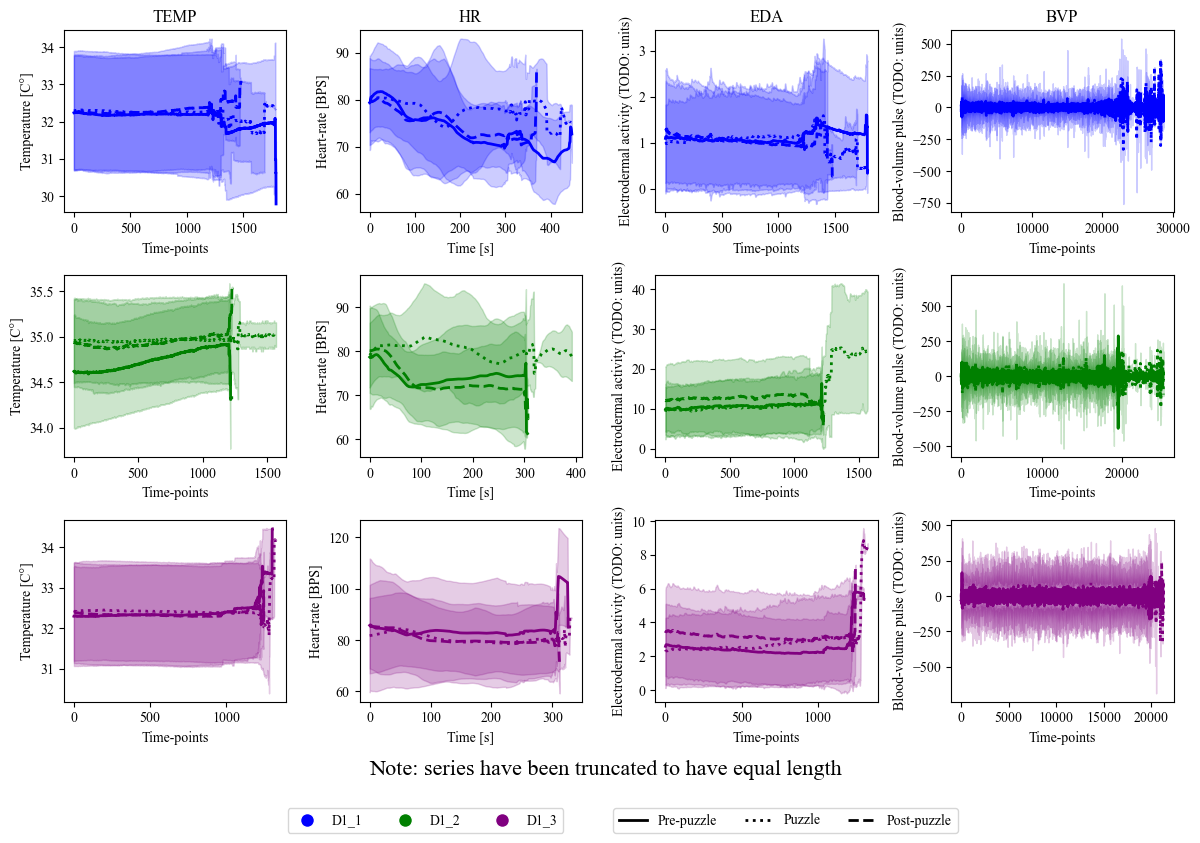

In [4]:
from matplotlib.lines import Line2D

measurements = ['TEMP', 'HR', 'EDA', 'BVP']
measurements_units = {
    'TEMP': 'Temperature [C' + '\u00b0' + ']',
    'HR': 'Heart-rate [BPS]',
    'EDA': 'Electrodermal activity (TODO: units)',
    'BVP': 'Blood-volume pulse (TODO: units)',
}
cohort_colors = {
    'D1_1': 'blue', 
    'D1_2': 'green',
    'D1_3': 'purple'
    }
lstyles = {
    1:'solid',
    2:'dotted',
    3:'dashed',
    }

# create empty dictionaries to store the average and standard deviation for each phase and cohort
avg_temp_dict = {}
std_temp_dict = {}
avg_hr_dict = {}
std_hr_dict = {}
avg_eda_dict = {}
std_eda_dict = {}
avg_bvp_dict = {}
std_bvp_dict = {}

min_len_temp = min(len(data_dict[cohort][id][round_][phase]['TEMP']['TEMP'].tolist()) for cohort in data_dict for id in data_dict[cohort] for round_ in data_dict[cohort][id] for phase in data_dict[cohort][id][round_])
min_len_hr = min(len(data_dict[cohort][id][round_][phase]['HR']['HR'].tolist()) for cohort in data_dict for id in data_dict[cohort] for round_ in data_dict[cohort][id] for phase in data_dict[cohort][id][round_])
min_len_eda = min(len(data_dict[cohort][id][round_][phase]['EDA']['EDA'].tolist()) for cohort in data_dict for id in data_dict[cohort] for round_ in data_dict[cohort][id] for phase in data_dict[cohort][id][round_])
min_len_bvp = min(len(data_dict[cohort][id][round_][phase]['BVP']['BVP'].tolist()) for cohort in data_dict for id in data_dict[cohort] for round_ in data_dict[cohort][id] for phase in data_dict[cohort][id][round_])

max_len_temp = max(len(data_dict[cohort][id][round_][phase]['TEMP']['TEMP'].tolist()) for cohort in data_dict for id in data_dict[cohort] for round_ in data_dict[cohort][id] for phase in data_dict[cohort][id][round_])
max_len_hr = max(len(data_dict[cohort][id][round_][phase]['HR']['HR'].tolist()) for cohort in data_dict for id in data_dict[cohort] for round_ in data_dict[cohort][id] for phase in data_dict[cohort][id][round_])
max_len_eda = max(len(data_dict[cohort][id][round_][phase]['EDA']['EDA'].tolist()) for cohort in data_dict for id in data_dict[cohort] for round_ in data_dict[cohort][id] for phase in data_dict[cohort][id][round_])
max_len_bvp = max(len(data_dict[cohort][id][round_][phase]['BVP']['BVP'].tolist()) for cohort in data_dict for id in data_dict[cohort] for round_ in data_dict[cohort][id] for phase in data_dict[cohort][id][round_])


merged_cohorts = {
    'D1_1': ['D1_1'],
    'D1_2': ['D1_2'],
    'D1_3': ['D1_3_1', 'D1_3_2', 'D1_3_3', 'D1_3_4'] 
}

for merged_cohort in merged_cohorts:
    for phase in ['phase1', 'phase2', 'phase3']:
        key = f'{merged_cohort}_{phase}'
        temp_list = []
        hr_list = []
        eda_list = []
        bvp_list = []

        for cohort in merged_cohorts[merged_cohort]:
            # iterate through each participant's data for a given phase in all rounds
            for round_ in ['round_1', 'round_2', 'round_3', 'round_4']:
                for id in data_dict[cohort].keys():
                    temp_ts = data_dict[cohort][id][round_][phase]['TEMP']['TEMP'].tolist()
                    hr_ts = data_dict[cohort][id][round_][phase]['HR']['HR'].tolist()
                    eda_ts = data_dict[cohort][id][round_][phase]['EDA']['EDA'].tolist()
                    bvp_ts = data_dict[cohort][id][round_][phase]['BVP']['BVP'].tolist()

                    # Series differ in length, not sure how we should solve this problem... for now I'll introduce truncation...
                    #if len(temp_ts) > min_len_temp:
                    #    temp_ts = temp_ts[:min_len_temp]

                    #if len(hr_ts) > min_len_hr:
                    #    hr_ts = hr_ts[:min_len_hr]

                    #if len(eda_ts) > min_len_eda:
                    #    eda_ts = eda_ts[:min_len_eda]

                    #if len(bvp_ts) > min_len_bvp:
                    #    bvp_ts = bvp_ts[:min_len_bvp]

                    # NaN-padding instead of truncation (Don't now what we prefer)
                    if len(temp_ts) < max_len_temp:
                        temp_ts += [np.nan] * (max_len_temp - len(temp_ts))

                    if len(hr_ts) < max_len_hr:
                        hr_ts += [np.nan] * (max_len_hr - len(hr_ts))

                    if len(eda_ts) < max_len_eda:
                        eda_ts += [np.nan] * (max_len_eda - len(eda_ts))

                    if len(bvp_ts) < max_len_bvp:
                        bvp_ts += [np.nan] * (max_len_bvp - len(bvp_ts))


                    temp_list.append(temp_ts)
                    hr_list.append(hr_ts)
                    eda_list.append(eda_ts)
                    bvp_list.append(bvp_ts)

        # compute average and standard deviation across all participants and rounds for the phase and cohort for each measurement type
        if len(temp_list) > 0:
            avg_temp = np.nanmean(np.vstack(temp_list), axis=0)
            std_temp = np.nanstd(np.vstack(temp_list), axis=0)
            if key not in avg_temp_dict:
                avg_temp_dict[key] = []
                std_temp_dict[key] = []
            avg_temp_dict[key].append(avg_temp)
            std_temp_dict[key].append(std_temp)

        if len(hr_list) > 0:
            avg_hr = np.nanmean(np.vstack(hr_list), axis=0)
            std_hr = np.nanstd(np.vstack(hr_list), axis=0)
            if key not in avg_hr_dict:
                avg_hr_dict[key] = []
                std_hr_dict[key] = []
            avg_hr_dict[key].append(avg_hr)
            std_hr_dict[key].append(std_hr)
        
        if len(eda_list) > 0:
            avg_eda = np.nanmean(np.vstack(eda_list), axis=0)
            std_eda = np.nanstd(np.vstack(eda_list), axis=0)
            if key not in avg_eda_dict:
                avg_eda_dict[key] = []
                std_eda_dict[key] = []
            avg_eda_dict[key].append(avg_eda)
            std_eda_dict[key].append(std_eda)

        if len(bvp_list) > 0:
            avg_bvp = np.nanmean(np.vstack(bvp_list), axis=0)
            std_bvp = np.nanstd(np.vstack(bvp_list), axis=0)
            if key not in avg_bvp_dict:
                avg_bvp_dict[key] = []
                std_bvp_dict[key] = []
            avg_bvp_dict[key].append(avg_bvp)
            std_bvp_dict[key].append(std_bvp)

results = {
        'TEMP': (avg_temp_dict, std_temp_dict),
        'HR': (avg_hr_dict, std_hr_dict),
        'EDA': (avg_eda_dict, std_eda_dict),
        'BVP': (avg_bvp_dict, std_bvp_dict),
}

# plot the data
fig, axs = plt.subplots(3, 4, figsize=(12, 8))
for i, cohort in enumerate(['D1_1', 'D1_2', 'D1_3']):
    for j, measr in enumerate(measurements):
        for l, phase in enumerate(['phase1', 'phase2', 'phase3']):
            ax = axs[i, j]
            if i == 0:
                ax.set_title(measr)
            if measr in ['TEMP','EDA', 'BVP']:
                ax.set_xlabel('Time-points')
            else:
                ax.set_xlabel('Time [s]')
            ax.set_ylabel(measurements_units[measr])

            res_avg_dict, res_std_dict = results[measr]
            key = f'{cohort}_{phase}'
            if key in res_avg_dict:
                avg_measr = res_avg_dict[key][0]
                std_measr = res_std_dict[key][0]
                color = cohort_colors[cohort]
                ax.plot(avg_measr, color=color, label=f'{phase}', linestyle=lstyles[l+1])
                ax.fill_between(
                    np.arange(len(avg_measr)),
                    avg_measr - std_measr,
                    avg_measr + std_measr,
                    alpha=0.2,
                    color=color
                )

legend_elements = [Line2D([0], [0], marker='o', color='w', label='D1_1', markerfacecolor='blue', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='D1_2', markerfacecolor='green', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='D1_3', markerfacecolor='purple', markersize=10)]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, bbox_to_anchor=(0.35, -0.1))
legend_elements = [Line2D([0], [0], linestyle='solid', color='k', label='Pre-puzzle', markerfacecolor='k', markersize=10),
                   Line2D([0], [0], linestyle='dotted', color='k', label='Puzzle', markerfacecolor='k', markersize=10),
                   Line2D([0], [0], linestyle='dashed', color='k', label='Post-puzzle', markerfacecolor='k', markersize=10)]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, bbox_to_anchor=(0.65, -0.1))
fig.subplots_adjust(bottom=0.3)
fig.suptitle('Note: series have been truncated to have equal length', fontsize=16,  y=0.0)
plt.tight_layout()
plt.show()

C:\Users\alex\AppData\Local\Temp\ipykernel_24452\3637289912.py:86: RuntimeWarning: Mean of empty slice
  avg_temp = np.nanmean(np.vstack(temp_list), axis=0)
C:\Users\alex\AppData\Local\Temp\ipykernel_24452\3637289912.py:95: RuntimeWarning: Mean of empty slice
  avg_hr = np.nanmean(np.vstack(hr_list), axis=0)
C:\Users\alex\AppData\Local\Temp\ipykernel_24452\3637289912.py:104: RuntimeWarning: Mean of empty slice
  avg_eda = np.nanmean(np.vstack(eda_list), axis=0)
C:\Users\alex\AppData\Local\Temp\ipykernel_24452\3637289912.py:113: RuntimeWarning: Mean of empty slice
  avg_bvp = np.nanmean(np.vstack(bvp_list), axis=0)


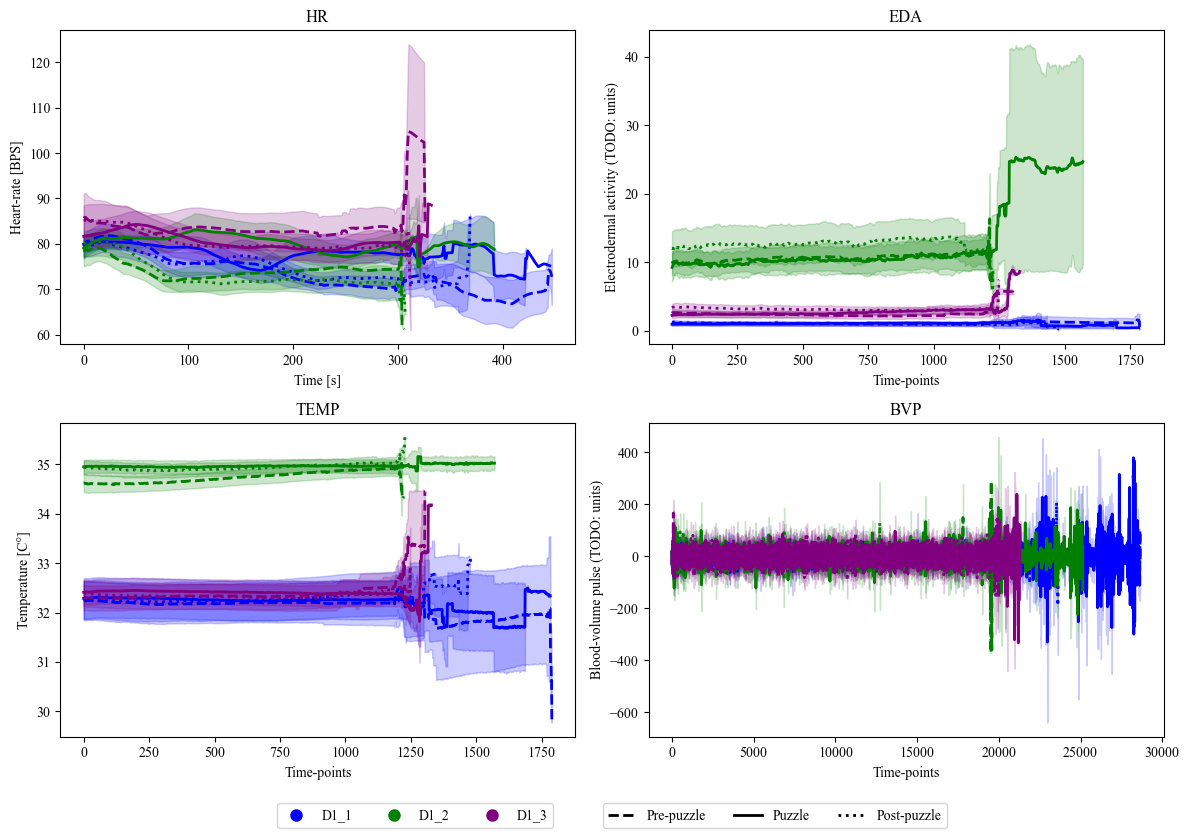

In [5]:
from matplotlib.lines import Line2D

measurements = ['HR', 'EDA','TEMP', 'BVP']
measurements_units = {
    'TEMP': 'Temperature [C' + '\u00b0' + ']',
    'HR': 'Heart-rate [BPS]',
    'EDA': 'Electrodermal activity (TODO: units)',
    'BVP': 'Blood-volume pulse (TODO: units)',
}
cohort_colors = {
    'D1_1': 'blue', 
    'D1_2': 'green',
    'D1_3': 'purple'
    }
lstyles = {
    1:'dashed',
    2:'solid',
    3:'dotted',
    }

# create empty dictionaries to store the average and standard deviation for each phase and cohort
avg_temp_dict = {}
se_temp_dict = {}
avg_hr_dict = {}
se_hr_dict = {}
avg_eda_dict = {}
se_eda_dict = {}
avg_bvp_dict = {}
se_bvp_dict = {}

min_len_temp = min(len(data_dict[cohort][id][round_][phase]['TEMP']['TEMP'].tolist()) for cohort in data_dict for id in data_dict[cohort] for round_ in data_dict[cohort][id] for phase in data_dict[cohort][id][round_])
min_len_hr = min(len(data_dict[cohort][id][round_][phase]['HR']['HR'].tolist()) for cohort in data_dict for id in data_dict[cohort] for round_ in data_dict[cohort][id] for phase in data_dict[cohort][id][round_])
min_len_eda = min(len(data_dict[cohort][id][round_][phase]['EDA']['EDA'].tolist()) for cohort in data_dict for id in data_dict[cohort] for round_ in data_dict[cohort][id] for phase in data_dict[cohort][id][round_])
min_len_bvp = min(len(data_dict[cohort][id][round_][phase]['BVP']['BVP'].tolist()) for cohort in data_dict for id in data_dict[cohort] for round_ in data_dict[cohort][id] for phase in data_dict[cohort][id][round_])

max_len_temp = max(len(data_dict[cohort][id][round_][phase]['TEMP']['TEMP'].tolist()) for cohort in data_dict for id in data_dict[cohort] for round_ in data_dict[cohort][id] for phase in data_dict[cohort][id][round_])
max_len_hr = max(len(data_dict[cohort][id][round_][phase]['HR']['HR'].tolist()) for cohort in data_dict for id in data_dict[cohort] for round_ in data_dict[cohort][id] for phase in data_dict[cohort][id][round_])
max_len_eda = max(len(data_dict[cohort][id][round_][phase]['EDA']['EDA'].tolist()) for cohort in data_dict for id in data_dict[cohort] for round_ in data_dict[cohort][id] for phase in data_dict[cohort][id][round_])
max_len_bvp = max(len(data_dict[cohort][id][round_][phase]['BVP']['BVP'].tolist()) for cohort in data_dict for id in data_dict[cohort] for round_ in data_dict[cohort][id] for phase in data_dict[cohort][id][round_])


merged_cohorts = {
    'D1_1': ['D1_1'],
    'D1_2': ['D1_2'],
    'D1_3': ['D1_3_1', 'D1_3_2', 'D1_3_3', 'D1_3_4'] 
}

for merged_cohort in merged_cohorts:
    for phase in ['phase1', 'phase2', 'phase3']:
        key = f'{merged_cohort}_{phase}'
        temp_list = []
        hr_list = []
        eda_list = []
        bvp_list = []

        for cohort in merged_cohorts[merged_cohort]:
            # iterate through each participant's data for a given phase in all rounds
            for round_ in ['round_1', 'round_2', 'round_3', 'round_4']:
                for id in data_dict[cohort].keys():
                    temp_ts = data_dict[cohort][id][round_][phase]['TEMP']['TEMP'].tolist()
                    hr_ts = data_dict[cohort][id][round_][phase]['HR']['HR'].tolist()
                    eda_ts = data_dict[cohort][id][round_][phase]['EDA']['EDA'].tolist()
                    bvp_ts = data_dict[cohort][id][round_][phase]['BVP']['BVP'].tolist()

                    # NaN-padding instead of truncation (Don't now what we prefer)
                    if len(temp_ts) < max_len_temp:
                        temp_ts += [np.nan] * (max_len_temp - len(temp_ts))

                    if len(hr_ts) < max_len_hr:
                        hr_ts += [np.nan] * (max_len_hr - len(hr_ts))

                    if len(eda_ts) < max_len_eda:
                        eda_ts += [np.nan] * (max_len_eda - len(eda_ts))

                    if len(bvp_ts) < max_len_bvp:
                        bvp_ts += [np.nan] * (max_len_bvp - len(bvp_ts))


                    temp_list.append(temp_ts)
                    hr_list.append(hr_ts)
                    eda_list.append(eda_ts)
                    bvp_list.append(bvp_ts)

        # compute average and standard deviation across all participants and rounds for the phase and cohort for each measurement type
        if len(temp_list) > 0:
            avg_temp = np.nanmean(np.vstack(temp_list), axis=0)
            se_temp = 1.44*np.nanstd(np.vstack(temp_list), axis=0)/np.sqrt(np.count_nonzero(~np.isnan(np.vstack(temp_list)), axis=0))
            if key not in avg_temp_dict:
                avg_temp_dict[key] = []
                se_temp_dict[key] = []
            avg_temp_dict[key].append(avg_temp)
            se_temp_dict[key].append(se_temp)

        if len(hr_list) > 0:
            avg_hr = np.nanmean(np.vstack(hr_list), axis=0)
            se_hr = 1.44*np.nanstd(np.vstack(hr_list), axis=0)/np.sqrt(np.count_nonzero(~np.isnan(np.vstack(hr_list)), axis=0))
            if key not in avg_hr_dict:
                avg_hr_dict[key] = []
                se_hr_dict[key] = []
            avg_hr_dict[key].append(avg_hr)
            se_hr_dict[key].append(se_hr)
        
        if len(eda_list) > 0:
            avg_eda = np.nanmean(np.vstack(eda_list), axis=0)
            se_eda = 1.44*np.nanstd(np.vstack(eda_list), axis=0)/np.sqrt(np.count_nonzero(~np.isnan(np.vstack(eda_list)), axis=0))
            if key not in avg_eda_dict:
                avg_eda_dict[key] = []
                se_eda_dict[key] = []
            avg_eda_dict[key].append(avg_eda)
            se_eda_dict[key].append(se_eda)

        if len(bvp_list) > 0:
            avg_bvp = np.nanmean(np.vstack(bvp_list), axis=0)
            se_bvp = 1.44*np.nanstd(np.vstack(bvp_list), axis=0)/np.sqrt(np.count_nonzero(~np.isnan(np.vstack(bvp_list)), axis=0))
            if key not in avg_bvp_dict:
                avg_bvp_dict[key] = []
                se_bvp_dict[key] = []
            avg_bvp_dict[key].append(avg_bvp)
            se_bvp_dict[key].append(se_bvp)

results = {
        'HR': (avg_hr_dict, se_hr_dict),
        'EDA': (avg_eda_dict, se_eda_dict),
        'TEMP': (avg_temp_dict, se_temp_dict),
        'BVP': (avg_bvp_dict, se_bvp_dict),
}

# plot the data
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for i, cohort in enumerate(['D1_1', 'D1_2', 'D1_3']):
    for j, measr in enumerate(measurements):
        i = j//2
        k = j%2
        for l, phase in enumerate(['phase1', 'phase2', 'phase3']):
            ax = axs[i, k]
            ax.set_title(measr)
            if measr in ['TEMP','EDA', 'BVP']:
                ax.set_xlabel('Time-points')
            else:
                ax.set_xlabel('Time [s]')
            ax.set_ylabel(measurements_units[measr])

            res_avg_dict, res_se_dict = results[measr]
            key = f'{cohort}_{phase}'
            if key in res_avg_dict:
                avg_measr = res_avg_dict[key][0]
                se_measr = res_se_dict[key][0]
                color = cohort_colors[cohort]
                ax.plot(avg_measr, color=color, label=f'{phase}', linestyle=lstyles[l+1])
                ax.fill_between(
                    np.arange(len(avg_measr)),
                    avg_measr - se_measr,
                    avg_measr + se_measr,
                    alpha=0.2,
                    color=color
                )

legend_elements = [Line2D([0], [0], marker='o', color='w', label='D1_1', markerfacecolor='blue', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='D1_2', markerfacecolor='green', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='D1_3', markerfacecolor='purple', markersize=10)]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, bbox_to_anchor=(0.35, -0.05))
legend_elements = [Line2D([0], [0], linestyle='dashed', color='k', label='Pre-puzzle', markerfacecolor='k', markersize=10),
                   Line2D([0], [0], linestyle='solid', color='k', label='Puzzle', markerfacecolor='k', markersize=10),
                   Line2D([0], [0], linestyle='dotted', color='k', label='Post-puzzle', markerfacecolor='k', markersize=10)]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, bbox_to_anchor=(0.65, -0.05))
fig.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()